In [1]:
import pandas as pd
import numpy as np
import os
import numpy
import matplotlib.pyplot as plt
import SimpleITK
import itertools
import sys
import torch
from torchvision import transforms
from PIL import Image
from matplotlib import cm
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
from torchvision import models

from pathlib import Path

SOURCE_PATH = Path(os.getcwd()) / 'src'

if SOURCE_PATH not in sys.path:
    sys.path.append(SOURCE_PATH)

from src.extraction import (
    export_all_images_jpeg,
    export_images_list_jpeg,
    get_images_lists_from_path,
    get_images_lists_from_more_paths
)

from src.plots import (
    plot_observation
)

from src.modelling import (
    train_model
)

%load_ext autoreload
%autoreload 2

In [2]:
hgg = Path(os.getcwd()) / 'data' / 'HGG'
lgg = Path(os.getcwd()) / 'data' / 'LGG'

In [3]:
t2, t1ce, t1, flair, seg = get_images_lists_from_path(hgg)
t2l, t1cel, t1l, flairl, segl = get_images_lists_from_path(lgg)

type_names = ['t2', 't1', 't1ce', 'flair', 'seg']
images = [t2, t1, t1ce, flair, seg]
imagesl = [t2l, t1l, t1cel, flairl, segl]
all_images = get_images_lists_from_more_paths([hgg,lgg])

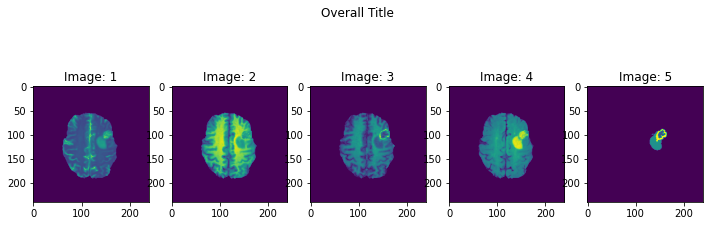

In [4]:
plot_observation(images, 0)

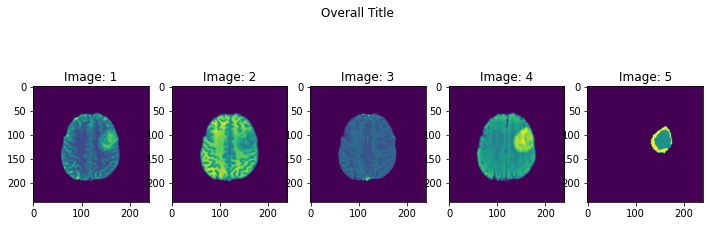

In [5]:
plot_observation(imagesl, 0)

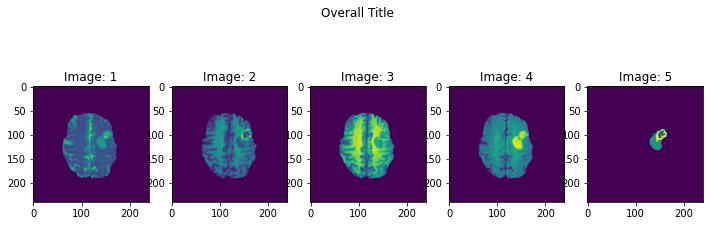

In [6]:
plot_observation(all_images, 0)

In [7]:
type_to_use = 'flair'
images_tensors = pad_sequence([torch.tensor(x.astype(np.int16)) for x in all_images[type_names.index(type_to_use)]], batch_first=True)
seg_tensors = pad_sequence([torch.tensor(x.astype(np.int16)) for x in all_images[type_names.index('seg')]], batch_first=True)

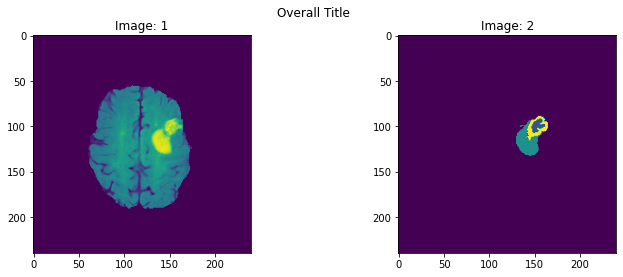

In [8]:
plot_observation([images_tensors, seg_tensors], 0)

In [9]:
def split_train_test_with_fract(tensors, frac_test=0.1):
    split = int(len(images_tensors) * (1-frac_test))
    return tensors[:split], tensors[split:]

In [52]:
train_img, test_img = split_train_test_with_fract(images_tensors)
train_seg, test_seg = split_train_test_with_fract(seg_tensors)

In [56]:
from torch.utils.data import Dataset

In [61]:
dataset = {
    'Train': {'image': train_img, 'masks': train_seg},
    'Test': {'image': test_img, 'masks': test_seg}
    }

In [62]:
images_dataloader = {
        x: DataLoader(dataset[x],
                      batch_size=10,
                      #shuffle=True, #to test without shuffle not done yet
                      #num_workers=8
                      )
        for x in ['Train', 'Test']
    }

In [44]:
model = models.segmentation.deeplabv3_mobilenet_v3_large(
    pretrained=True,
    progress=True
)

In [ ]:
import time
import copy
from sklearn.metrics import f1_score

since = time.time()
best_model_wts = copy.deepcopy(model.state_dict())
best_loss = 1e10
metrics = {'f1_score': f1_score}
num_epochs = 2

# Use gpu if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
    # Initialize the log file for training and testing loss and metrics
fieldnames = ['epoch', 'Train_loss', 'Test_loss'] + \
    [f'Train_{m}' for m in metrics.keys()] + \
    [f'Test_{m}' for m in metrics.keys()]

for epoch in range(1, num_epochs + 1):
    print('Epoch {}/{}'.format(epoch, num_epochs))
    print('-' * 10)
        # Each epoch has a training and validation phase
        # Initialize batch summary
    batchsummary = {a: [0] for a in fieldnames}

    for phase in ['Train', 'Test']:
        if phase == 'Train':
            model.train()  # Set model to training mode
        else:
            model.eval()  # Set model to evaluate mode

        # Iterate over data.
        for sample in tqdm(iter(dataloaders[phase])):
            inputs = sample['image'].to(device)
            masks = sample['mask'].to(device)
            # zero the parameter gradients
            optimizer.zero_grad()

            # track history if only in train
            with torch.set_grad_enabled(phase == 'Train'):
                outputs = model(inputs)
                loss = criterion(outputs['out'], masks)
                y_pred = outputs['out'].data.cpu().numpy().ravel()
                y_true = masks.data.cpu().numpy().ravel()
                for name, metric in metrics.items():
                    if name == 'f1_score':
                        # Use a classification threshold of 0.1
                        batchsummary[f'{phase}_{name}'].append(
                            metric(y_true > 0, y_pred > 0.1))
                    else:
                        batchsummary[f'{phase}_{name}'].append(
                            metric(y_true.astype('uint8'), y_pred))

                # backward + optimize only if in training phase
                if phase == 'Train':
                    loss.backward()
                    optimizer.step()
        batchsummary['epoch'] = epoch
        epoch_loss = loss
        batchsummary[f'{phase}_loss'] = epoch_loss.item()
        print('{} Loss: {:.4f}'.format(phase, loss))
    for field in fieldnames[3:]:
        batchsummary[field] = np.mean(batchsummary[field])
    print(batchsummary)
        # deep copy the model
        if phase == 'Test' and loss < best_loss:
            best_loss = loss
            best_model_wts = copy.deepcopy(model.state_dict())

time_elapsed = time.time() - since
print('Training complete in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))
print('Lowest Loss: {:4f}'.format(best_loss))

# load best model weights
model.load_state_dict(best_model_wts)

In [40]:
# from sklearn.metrics import f1_score

# train_model(
#     model = model, 
#     criterion = torch.nn.MSELoss(reduction='mean'), 
#     dataloaders = images_dataloader, 
#     optimizer = torch.optim.Adam(model.parameters(), lr=1e-4), 
#     metrics = {'f1_score': f1_score}, 
#     bpath = str(Path(os.getcwd()) / 'models'),
#     num_epochs = 2)

In [ ]:
model_exp_name = 'flair_not_shuffle_totalpipe'
torch.save(model, str(Path(os.getcwd()) / 'models') / model_exp_name + '.pt')